In [19]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split,StratifiedKFold # Model evaluation
from sklearn.preprocessing import LabelEncoder, RobustScaler, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet,  LassoLarsIC, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone, BaseEstimator, TransformerMixin, RegressorMixin # Clone estimator
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import explained_variance_score, f1_score, roc_auc_score, median_absolute_error, r2_score, mean_squared_error #To evaluate our model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor, LGBMRegressor
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 

In [20]:
import pandas as pd
import numpy as np
import re
import numpy as np

In [21]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
testId = test.Property_Id
train.Price_Category = train.Price_Category.replace("Cheap",0).replace("Affordable",1).replace("Semi-Premium",2).replace("Premium",3)
y = train.Price_Category
train = train.drop(["Property_Id", "Price_Category"],axis=1)
test = test.drop(["Property_Id"],axis=1)
train = pd.concat([train,test])
train.head(1)

Title  \
0  Brand New 1 Kanal House For Sale In Bahria Tow...   

                                               Label   Type  \
0  Bahria Town - Gulbahar Block, Bahria Town - Se...  House   

                      Location Baths     Area   Purpose Bedroom(s)  \
0  Bahria Town, Lahore, Punjab     6  1 Kanal  For Sale          5   

                                         Description  \
0  Brand New 1 Kanal House For Sale In Bahria Tow...   

                                       Main Features  \
0   Built in year: 2018 , Parking Spaces: 4 , Dou...   

                                               Rooms  \
0   Bedrooms: 5 , Bathrooms: 7 , Servant Quarters...   

                          Business and Communication  \
0   Broadband Internet Access , Satellite or Cabl...   

           Healthcare Recreational  \
0   Lawn or Garden , Swimming Pool   

               Nearby Locations and Other Facilities  \
0   Nearby Schools , Nearby Hospitals , Nearby Sh...   

                                    Other Facilities    Popular       Source  \
0   Maintenance Staff , Security Staff , Faciliti...  super hot  Lahore-1-10   

        Time Stamp  
0  3/31/2019 11:01

In [22]:
train.Area = ["".join(x.split(",")) for x in train.Area]

In [23]:
train["nearbyVal"] = [1 if len(x) > 1 else 0 for x in train["Nearby Locations and Other Facilities"]]
train["bussinessVal"] = [1 if len(x) > 1 else 0 for x in train["Business and Communication"]]
train["staffVal"] = [1 if len(x) > 1 else 0 for x in train["Other Facilities"]]
train["healthVal"] = [1 if len(x) > 1 else 0 for x in train["Healthcare Recreational"]]

In [24]:
def findWcolon(a,x, length):
    val = re.findall("%s: \d+" % a,x)
    val = val[0][-length:] if len(val)>0 else (np.nan if len(x)==1 else 0)
    return val
def find(a,x):
    return 1 if a in x else (np.nan if len(x)==1 else 0)

def rooms(x):
    living = find("Study Room",x) + find("Drawing Room",x) + find("Dining Room",x) + find("Lounge or Sitting Room", x)
    athletic = find("Gym",x) + find("Steam Room",x) + find("Laundry Room",x) + find("Powder Room", x)
    #findWcolon("Bathrooms",x,1),
    return [findWcolon("Servant Quarters",x,1), findWcolon("Kitchens",x,1), findWcolon("Store Rooms",x,1), living, athletic, find("Other Rooms", x), find("Steam Room",x), find("Laundry Room",x), find("Powder Room", x), find("Study Room",x), find("Drawing Room",x), find("Dining Room",x), find("Lounge or Sitting Room", x)]

def main_features(x):
    return [findWcolon("Built in year",x,4), findWcolon("Parking Spaces",x,1), findWcolon("Floors",x,1), find("Double Glazed Windows", x), find("Flooring", x), find("Electricity Backup", x), find("Waste Disposal", x),find("Central Air Conditioning", x), find("Flooring", x)]

def business(x):
    return [find("Broadband Internet Access", x), find("Satellite or Cable TV Ready", x), find("Intercom", x), find("Other Business and Communication Facilities", x)]

def health(x):
    return [find("Lawn or Garden", x), find("Sauna", x) + find("Jacuzzi", x), find("Swimming Pool", x), find("Other Healthcare and Recreation Facilities", x)]

def facilities(x):
    cols = ['Maintenance Staff','Security Staff','Facilities for Disabled','Other Facilities']
    return [find(y,x) for y in cols]

def nearby(x):
    val = len([y for y in x.split(" , ") if "Nearby" in y]) if x != " " else np.nan
    return val

train[["Date","Parking","Floors","Windows", "Flooring", "ElectricBackup", "WasteDisposal", "CentralAir", "CentralHeating"]] = list(train["Main Features"].apply(main_features))

train[["Servants","Kitchens","Store Rooms", "living","healthRooms","OtherRooms", "Steam Room","Laundry Room","Powder Room","Study Room","Drawing Room","Dining Room","Lounge"]] = list(train.Rooms.apply(rooms))

train[["internet","tv","intercom","otherBusiness"]] = list(train["Business and Communication"].apply(business))

train[["town","city","province"]] = list(train.Location.apply(lambda x: x.split(",")))

train[["lawn","hotTub","pool","otherHealth"]] = list(train["Healthcare Recreational"].apply(health))

train.Area = train.Area.apply(lambda x: float(x.split(" ")[0]) if x.split(" ")[1] == "Marla" else float(x.split(" ")[0]) *20)

train[['MaintenanceStaff','SecurityStaff','FacilitiesDisabled','ExtraFacilities']] = list(train["Other Facilities"].apply(facilities))
    
train["nearby2"] = train["Nearby Locations and Other Facilities"].apply(nearby)


In [25]:
train.Popular = train.Popular.replace("hot",1).replace("super hot",2)
train = pd.concat([train,pd.get_dummies(train.Location)],axis=1)
#train = pd.concat([train,pd.get_dummies(train.city)],axis=1)
train = train.replace("-",0)

In [26]:
train = train.drop(["Title","Label","Date", "city", "province", "town","Type","Purpose", "Healthcare Recreational", "Other Facilities", "Rooms","Nearby Locations and Other Facilities","Main Features", "Source", "Time Stamp", "Description", "Location", "Business and Communication"],axis=1)

In [27]:
train = train.fillna(0)
train = train.astype('int')

In [28]:
Xtrain = train[:len(y)]
Xtest = train[len(y):]

<ipython-input-29-75660db29049>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(x,figsize = (20,.5))


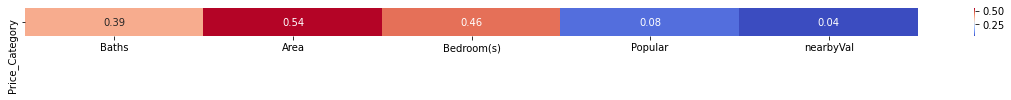

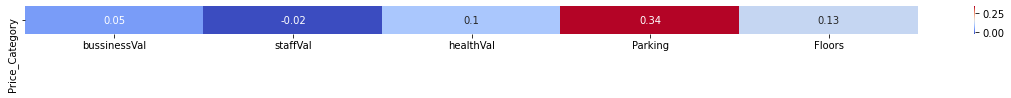

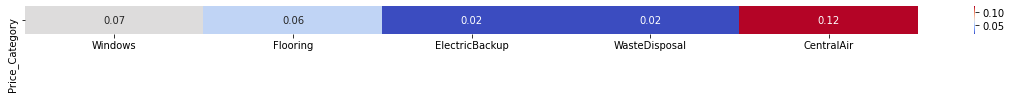

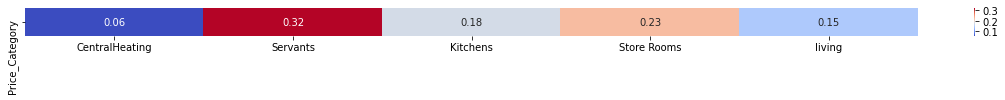

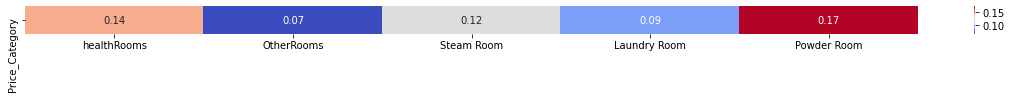

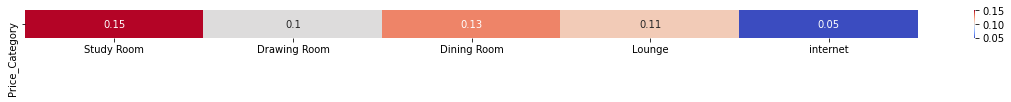

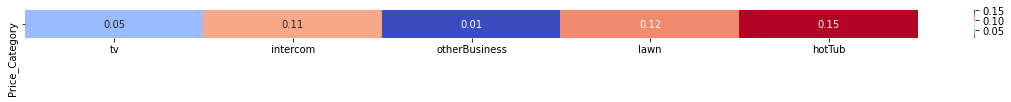

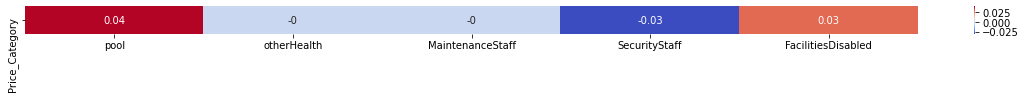

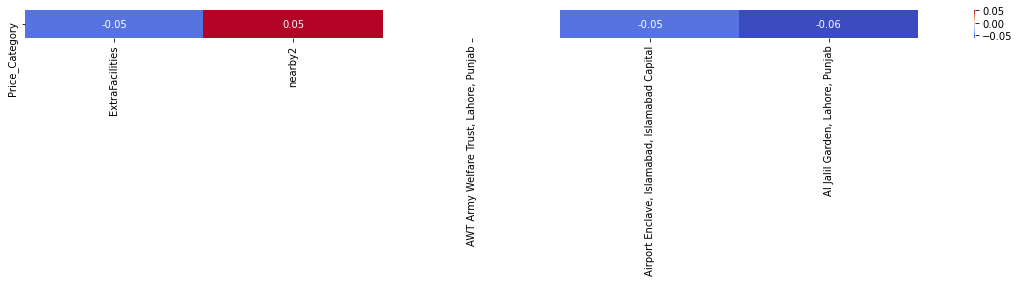

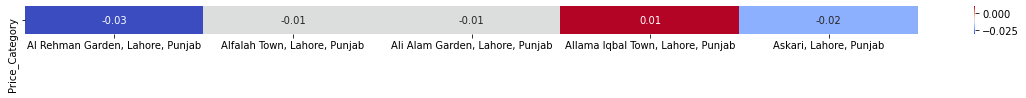

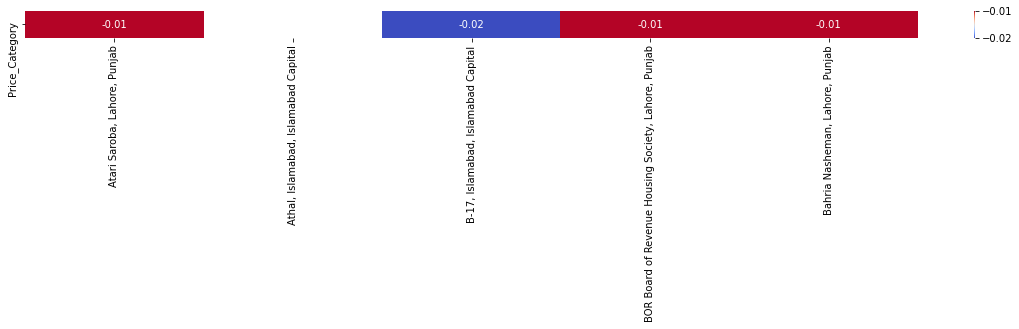

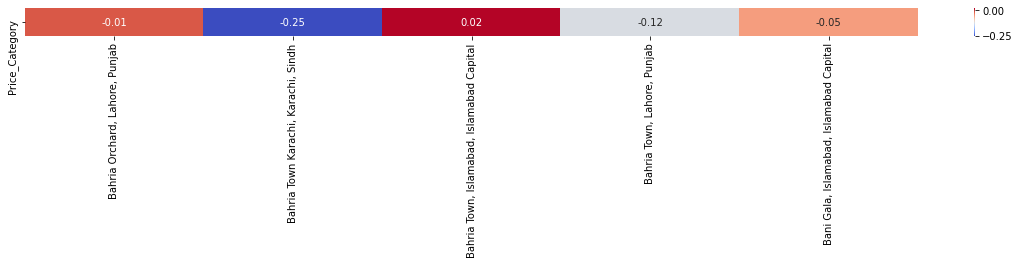

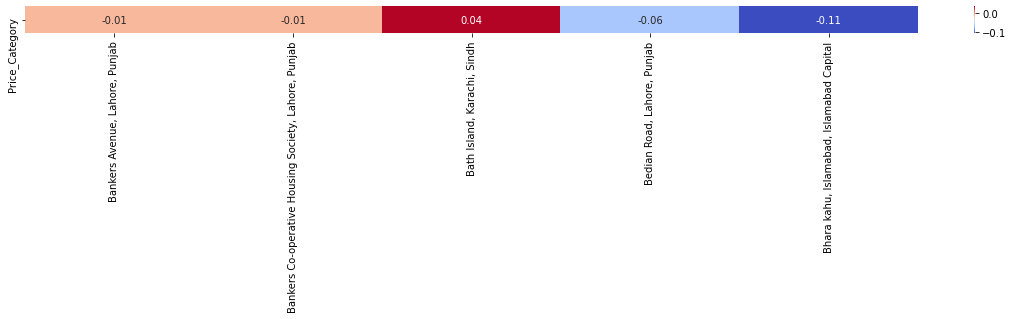

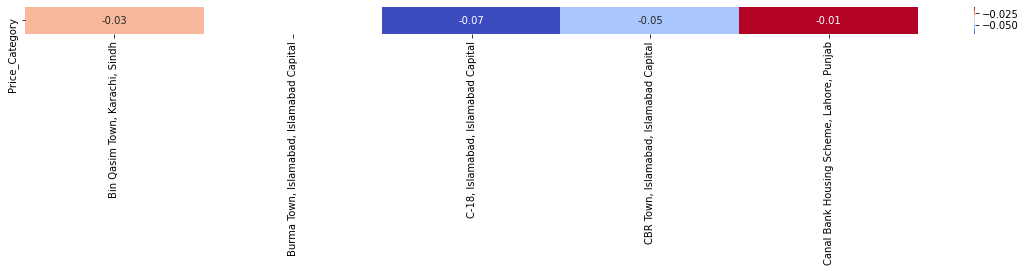

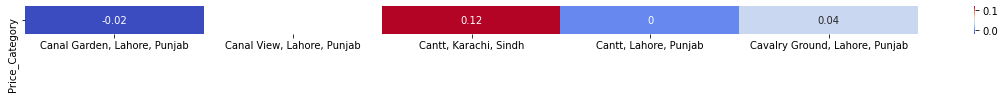

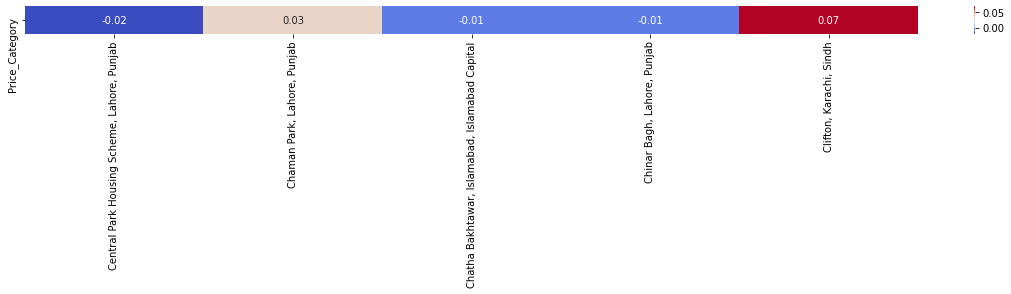

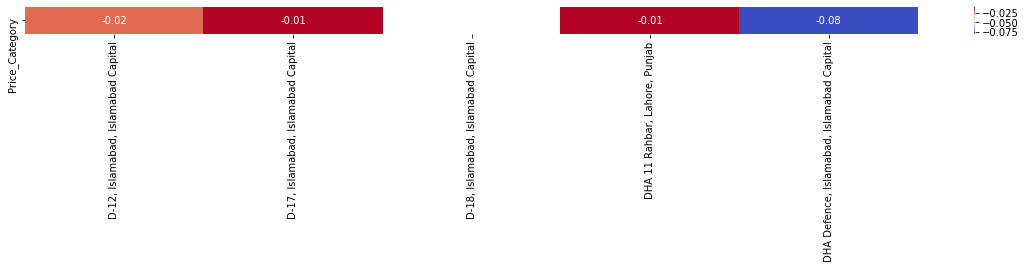

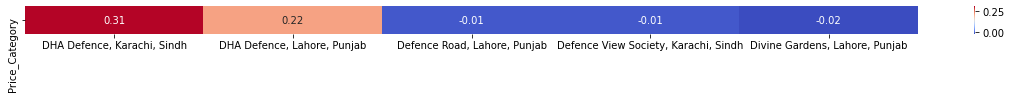

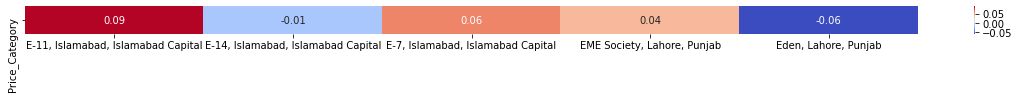

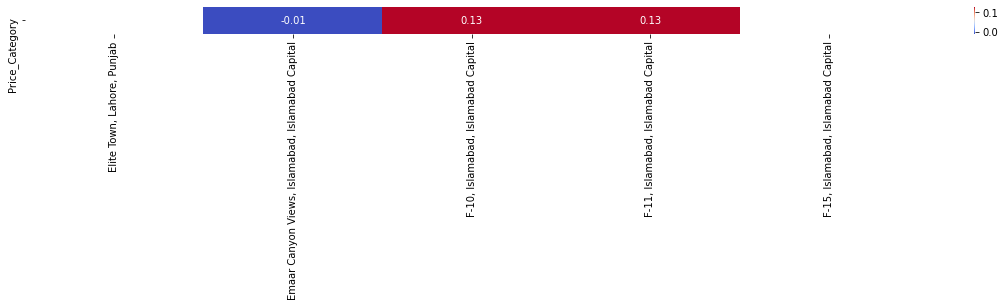

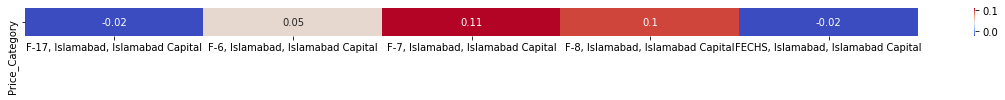

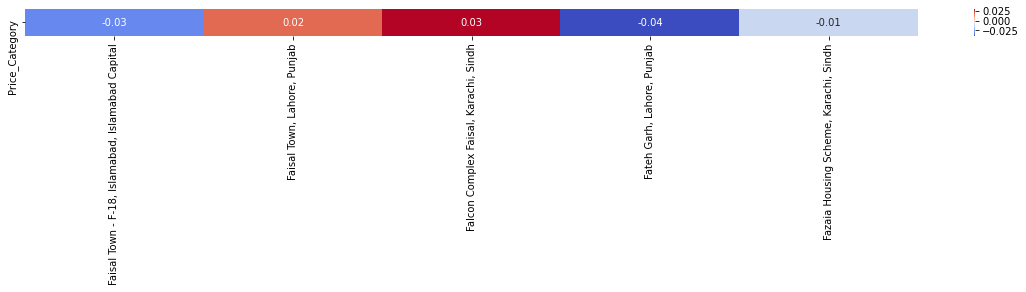

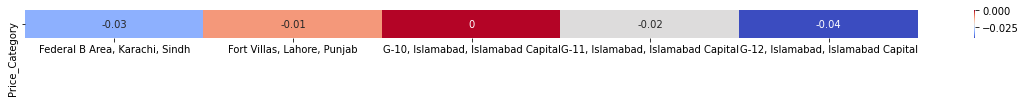

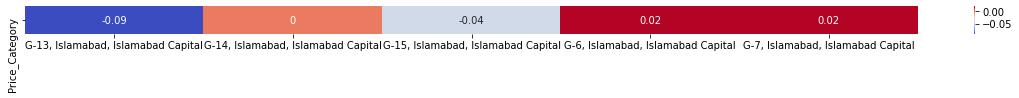

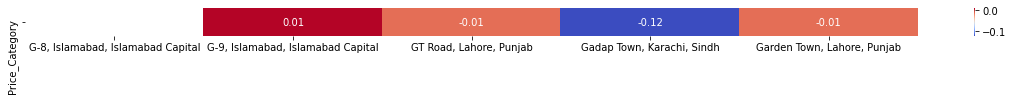

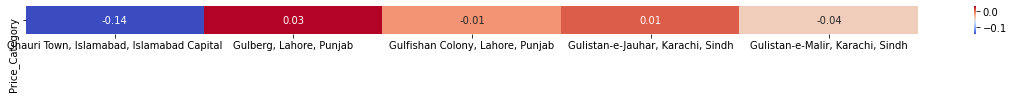

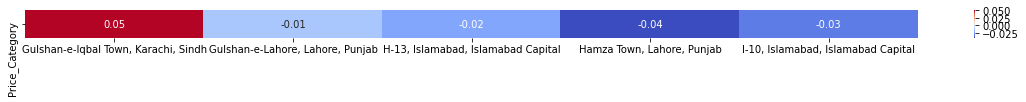

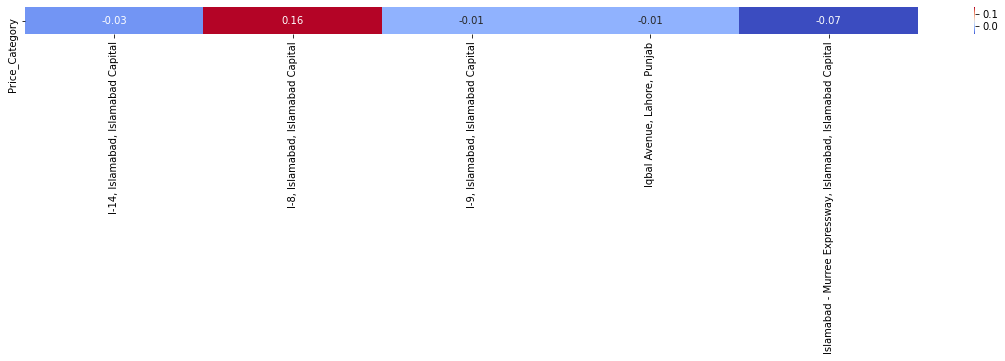

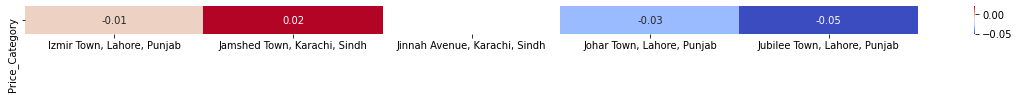

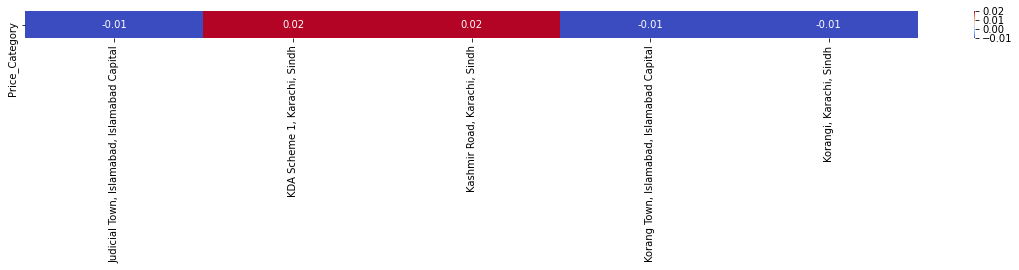

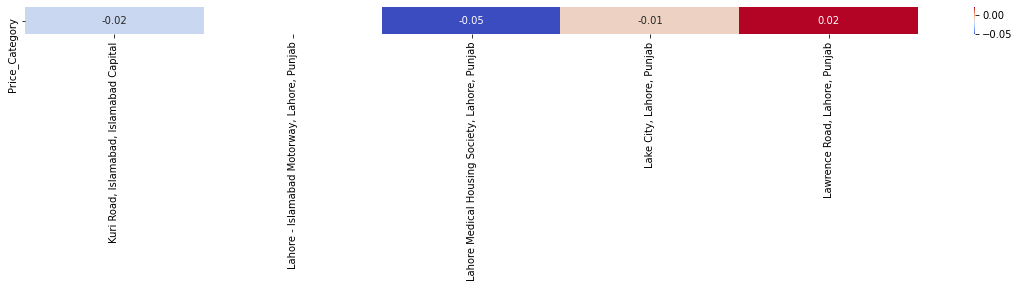

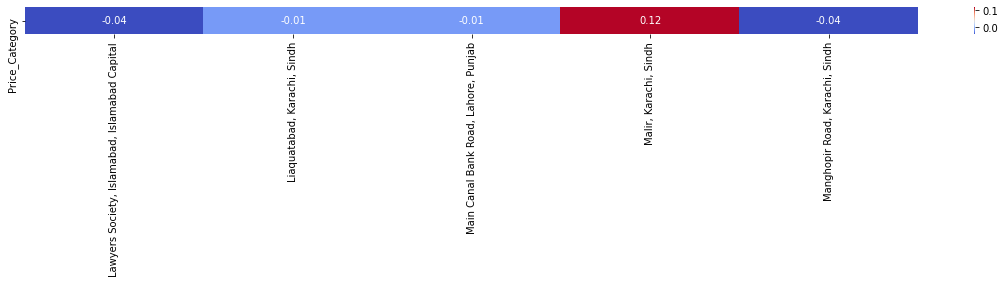

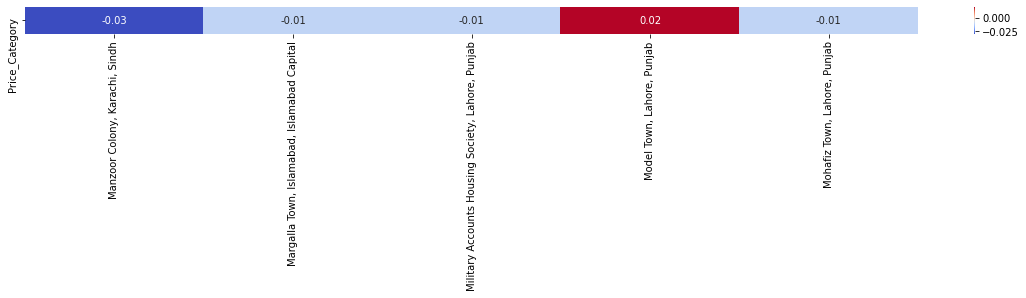

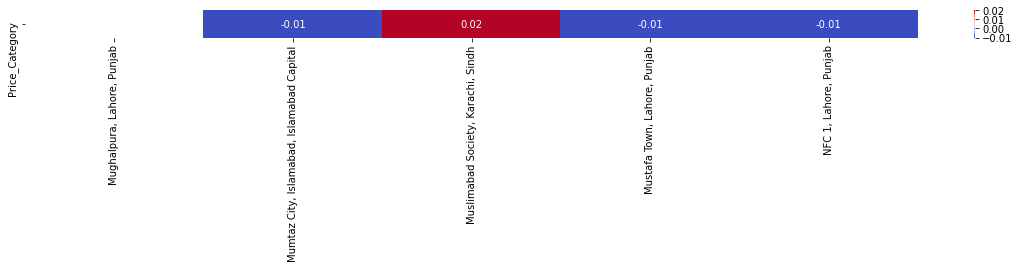

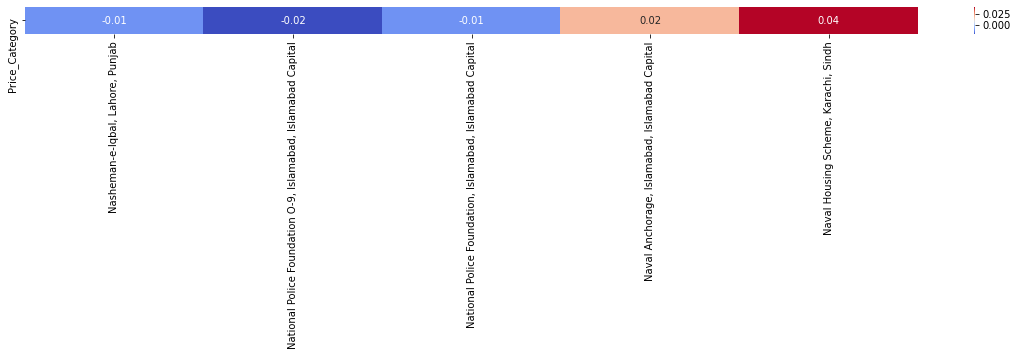

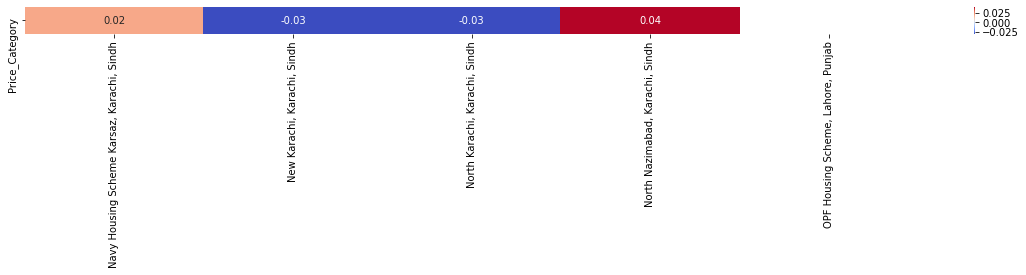

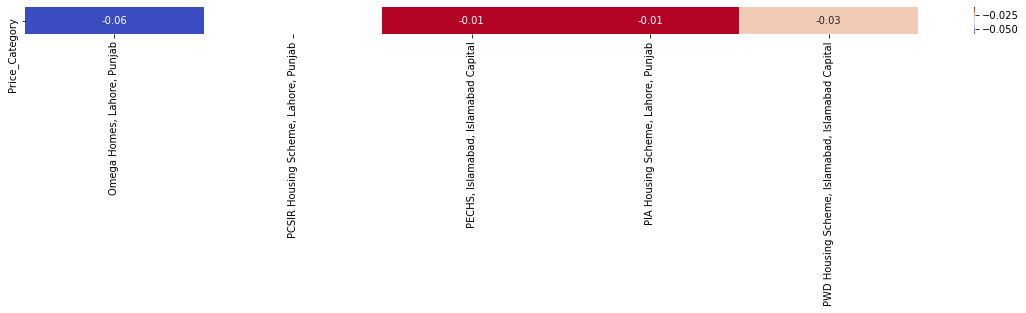

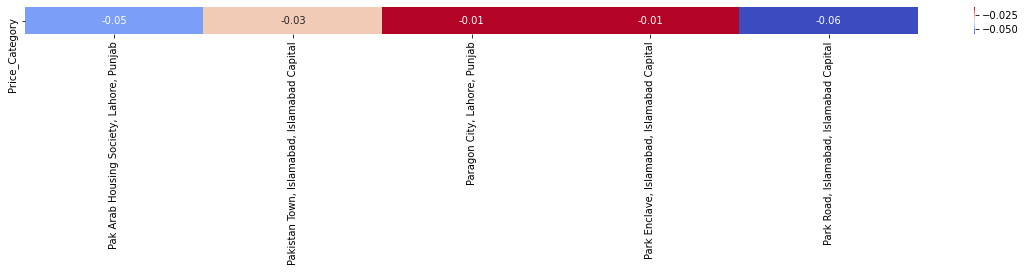

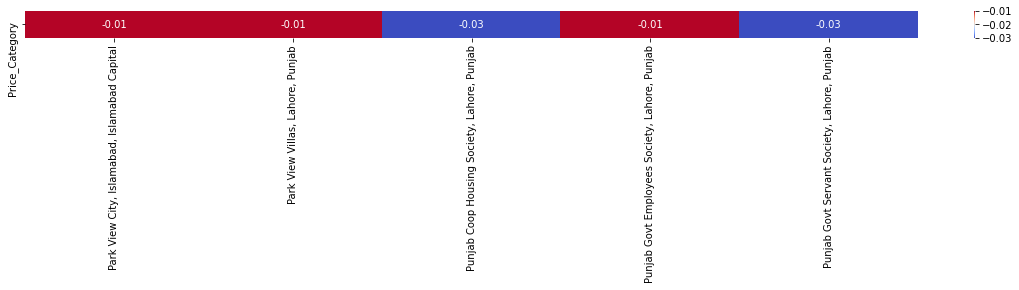

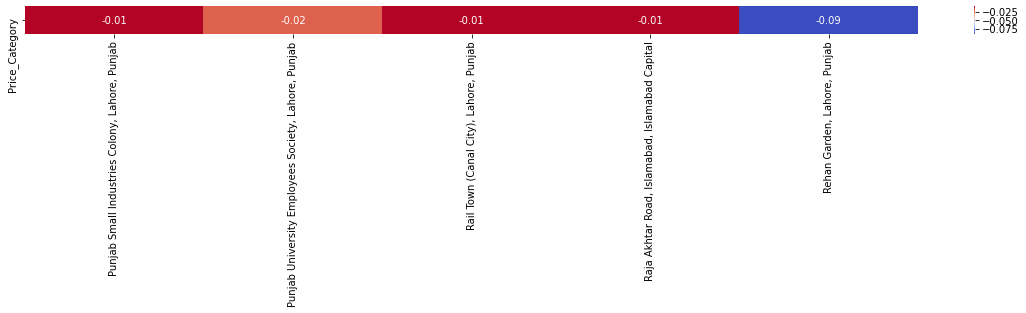

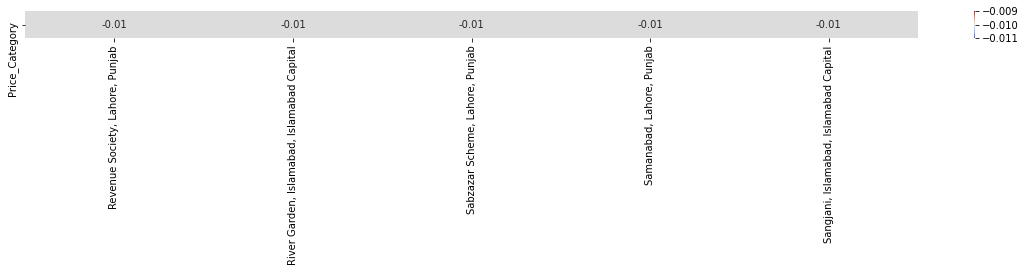

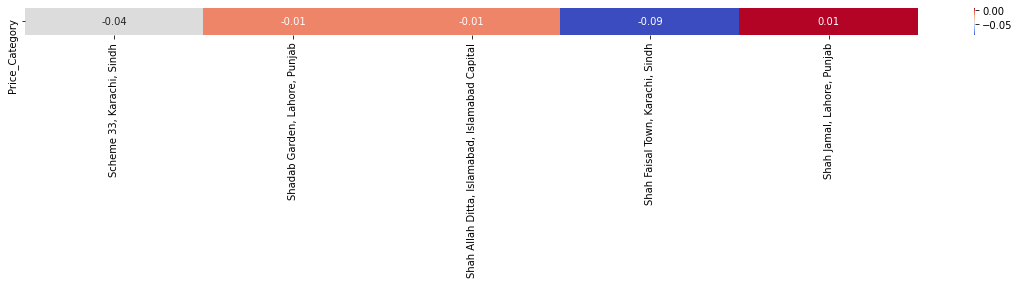

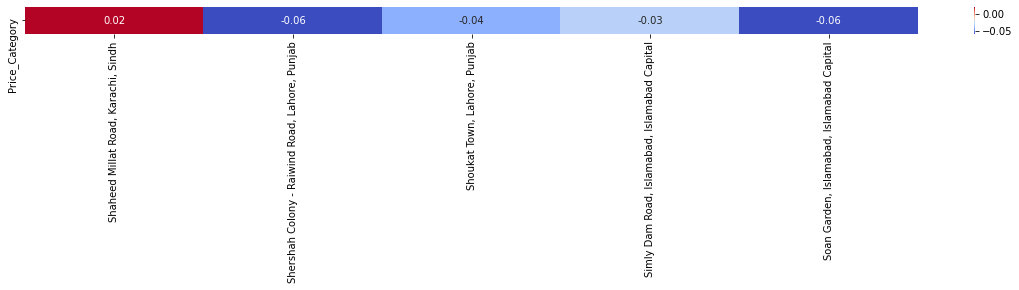

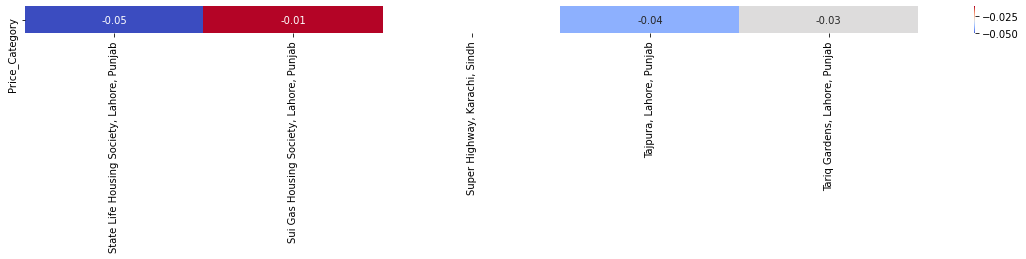

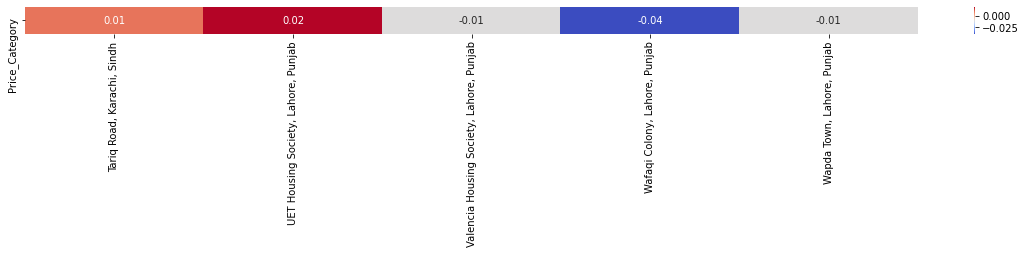

In [29]:
from math import ceil
train = pd.concat([Xtrain,y],axis=1)
correlation_matrix = train.corr().round(2)
matrix = correlation_matrix.loc[["Price_Category"]]
for x in range(ceil((len(Xtrain.columns)-5)/5)):
    plt.figure(x,figsize = (20,.5))
    sns.heatmap(data=matrix.iloc[:,x*5:min(len(train),(x+1)*5)], cmap="coolwarm",annot=True)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(Xtrain, y, test_size=0.33, random_state=42)
model = xgb.XGBRegressor()
model.fit(X_train,y_train)
predictions = model.predict(X_test).round(0)
f1_score(y_test, predictions, average='macro')



0.6612109553832111

In [31]:
Xtrain = Xtrain.values
Xtest = Xtest.values

In [32]:
def run_model(name, model,train,y,test):
    X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.33, random_state=42)
    model2 = model
    model2.fit(X_train,y_train)
    predictions = model.predict(X_test).round(0)
    print("%s F1 %s" % (name,f1_score(y_test, predictions, average='macro')))
    model.fit(train,y)
    preds = model.predict(test).round(0)
    return preds

In [33]:
# params={'metric': 'auc', 'reg_alpha': 6.010538011450937, 'reg_lambda': 0.031702113663443346, 'colsample_bytree': 0.27,
#    'subsample': 0.6, 'learning_rate': 0.05, 'max_depth': 100, 'num_leaves': 100, 'min_child_samples': 216,
#    'cat_smooth': 87, 'random_state': 48,'n_estimators': 20000}
# preds = np.zeros(test.shape[0])        
# kf = StratifiedKFold(n_splits=5,random_state=48,shuffle=True) #As we can see the data is unbalanced that's why I'll use StratifiedKFold to split data: Don't want all zeros in a split                 
# auc=[]   # list contains AUC for each fold  
# n=0   
# for trn_idx, test_idx in kf.split(Xtrain,y):
#     X_tr,X_val=Xtrain[trn_idx],Xtrain[test_idx]
#     y_tr,y_val=y[trn_idx],y[test_idx]
#     model = LGBMRegressor(**params) 
#     model.fit(X_tr,y_tr,eval_set=[(X_val,y_val)],early_stopping_rounds=100,verbose=False) 
#     preds+=model.predict(Xtest)/kf.n_splits 
#     auc.append(f1_score(y_val, model.predict(X_val).round(0),average="macro")) 
#     print(n+1,auc[n])                                                                                       
#     n+=1    

In [34]:
# model = LGBMRegressor()
# seed = 5
# n_folds =5
# scoring='neg_mean_squared_error'
# kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
# np.sqrt(-cross_val_score(model, Xtrain, y, cv= kfold,
#                                  scoring=scoring, n_jobs=1)) 

In [35]:
models = [
    ("KNN",KNeighborsClassifier(n_neighbors=5)),
    ("LGBM",LGBMRegressor()),
    ("XGB",XGBRegressor())
]
for name,model in models:
    run_model(name, model, Xtrain,y,Xtest)

KNN F1 0.6653191342707472
LGBM F1 0.6789106131584962
XGB F1 0.6612109553832111


In [113]:
preds = [["Cheap","Affordable","Semi-Premium","Premium"][int(x)] for x in preds.round(0)]

In [121]:
sub = pd.DataFrame({"Property_Id":testId,"Price_Category":preds})

In [123]:
sub.to_csv("../output/sub3.csv",index=False)

In [124]:
pd.read_csv("../output/sub3.csv").Price_Category.value_counts()

Semi-Premium    326
Premium         195
Affordable       23
Cheap             1
Name: Price_Category, dtype: int64

In [122]:
sub["Price_Category"].value_counts()

Semi-Premium    326
Premium         195
Affordable       23
Cheap             1
Name: Price_Category, dtype: int64

In [117]:
sub

['Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Premium',
 'Semi-Premium',
 'Affordable',
 'Semi-Premium',
 'Premium',
 'Semi-Premium',
 'Premium',
 'Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Premium',
 'Premium',
 'Premium',
 'Affordable',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Premium',
 'Semi-Premium',
 'Semi-Premium',
 'Premium',
 'Semi-Premium',
 'Premium',
 'Semi-Premium',
 'Premium',
 'Premium',
 'Premium',
 'Semi-Premium',
 'Premium',
 'Semi-Premium',
 'Premium',
 'Affordable',
 'Semi-Premium',
 'Prem